In [1]:
import sys
sys.path.append('/home/jjwhit/rcGAN')


In [2]:
run /home/jjwhit/rcGAN/train.py --config /home/jjwhit/rcGAN/configs/mass_map.yml --exp-name full_debug --num-gpus 1

/home/jjwhit/rcGAN/fastmri/__init__.py:16: UserWarning: Could not retrieve fastmri version!
  warnings.warn("Could not retrieve fastmri version!")
[rank: 0] Global seed set to 0


Experiment Name: full_debug
Number of GPUs: 1
Device count:  1
Config file path: /home/jjwhit/rcGAN/configs/mass_map.yml


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: jess-j-whitney. Use `wandb login --relogin` to force relogin
wandb: WARNING Path /share/gpu0/jjwhit/mass_map/mm_models/wandb/wandb/ wasn't writable, using system temp directory.
wandb: WARNING Path /share/gpu0/jjwhit/mass_map/mm_models/wandb/wandb/ wasn't writable, using system temp directory


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[rank: 0] Global seed set to 0
Initializing distributed: GLOBAL_RANK: 0, MEMBER: 1/1
[W socket.cpp:426] [c10d] The server socket cannot be initialized on [::]:21864 (errno: 97 - Address family not supported by protocol).
[W socket.cpp:601] [c10d] The client socket cannot be initialized to connect to [compute-gpu-0-3.local]:21864 (errno: 97 - Address family not supported by protocol).
[W socket.cpp:601] [c10d] The client socket cannot be initialized to connect to [compute-gpu-0-3.local]:21864 (errno: 97 - Address family not supported by protocol).
----------------------------------------------------------------------------------------------------
distributed_backend=nccl
All distributed processes registered. Starting with 1 processes
----------------------------------------------------------------------------------------------------

/ho

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

/home/jjwhit/.conda/envs/cGAN/lib/python3.8/site-packages/pytorch_lightning/trainer/call.py:48: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


## Bugfixing Mask

In [1]:
import numpy as np

In [2]:
kappa = np.load('/share/gpu0/jjwhit/kappa_cosmos_simulations/cropped_dataset/kappa_test/cropped_sim_01000.npy', allow_pickle=True)

In [3]:
std1 = np.load('/home/jjwhit/rcGAN/mass_map_utils/cosmos/cosmos_std1.npy', allow_pickle=True)
std2 = np.load('/home/jjwhit/rcGAN/mass_map_utils/cosmos/cosmos_std2.npy', allow_pickle=True)
im_size = 300

In [4]:
def compute_fourier_kernel(N: int) -> np.ndarray:
    """Computes the Fourier space kernel which represents the mapping between 
        convergence (kappa) and shear (gamma).

    Args:
        N (int): x,y dimension of image patch (assumes square images).

    Returns:
        D (np.ndarray): Fourier space Kaiser-Squires kernel, with shape = [N,N].
    """
    # Generate grid of Fourier domain
    kx = np.arange(N).astype(np.float64) - N/2
    ky, kx = np.meshgrid(kx, kx)
    k = kx**2 + ky**2
    # Define Kaiser-Squires kernel
    D = np.zeros((N, N), dtype=np.complex128)
    # D = np.where(k > 0, ((kx ** 2.0 - ky ** 2.0) + 1j * (2.0 * kx * ky))/k, D)
    # Another formulation to avoid divide by zero warning
    D[k>0] = (((kx ** 2.0 - ky ** 2.0) + 1j * (2.0 * kx * ky))[k>0]/k[k>0])
    # Apply inverse FFT shift 
    return np.fft.ifftshift(D)

In [5]:
def forward_model(kappa: np.ndarray, D: np.ndarray) -> np.ndarray:
        """Applies the forward mapping between convergence and shear through their 
            relationship in Fourier space.

        Args:
            kappa (np.ndarray): Convergence field, with shape [N,N].
            D (np.ndarray): Fourier space Kaiser-Squires kernel, with shape = [N,N].

        Returns:
            gamma (np.ndarray): Shearing field, with shape [N,N].
        """
        F_kappa = np.fft.fft2(kappa) # Perform 2D forward FFT
        F_gamma = F_kappa * D # Map convergence onto shear
        return np.fft.ifft2(F_gamma)

In [6]:
def gamma_gen(kappa):
    D = compute_fourier_kernel(im_size)
    gamma = forward_model(kappa, D) + (
            std1 * np.random.randn(im_size,im_size) + 1.j * std2 * np.random.randn(im_size, im_size)
        )
    return gamma

In [7]:
gamma_test = gamma_gen(kappa)

In [8]:
import matplotlib.pyplot as plt
import torch
from typing import Union, Tuple

In [9]:
def normalize(
    data: torch.Tensor,
    mean: Union[float, torch.Tensor],
    stddev: Union[float, torch.Tensor],
    eps: Union[float, torch.Tensor] = 0.0,
) -> torch.Tensor:
    """
    Normalize the given tensor.

    Applies the formula (data - mean) / (stddev + eps).

    Args:
        data: Input data to be normalized.
        mean: Mean value.
        stddev: Standard deviation.
        eps: Added to stddev to prevent dividing by zero.

    Returns:
        Normalized tensor.
    """
    return (data - mean) / (stddev + eps)


def normalize_instance(
    data: torch.Tensor, eps: Union[float, torch.Tensor] = 0.0
) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    """
    Normalize the given tensor  with instance norm/

    Applies the formula (data - mean) / (stddev + eps), where mean and stddev
    are computed from the data itself.

    Args:
        data: Input data to be normalized
        eps: Added to stddev to prevent dividing by zero.

    Returns:
        torch.Tensor: Normalized tensor
    """
    mean = data.mean()
    std = data.std()

    return normalize(data, mean, std, eps), mean, std

def to_tensor(data: np.ndarray) -> torch.Tensor:
    """
    Convert numpy array to PyTorch tensor.

    For complex arrays, the real and imaginary parts are stacked along the last
    dimension.

    Args:
        data: Input numpy array.

    Returns:
        PyTorch version of data.
    """
    if np.iscomplexobj(data):
        data = np.stack((data.real, data.imag), axis=-1)

    return torch.from_numpy(data)

In [10]:
pt_gamma = to_tensor(gamma_test)
print(pt_gamma.shape)

torch.Size([300, 300, 2])


In [11]:
normalized_gamma, mean, std = normalize_instance(pt_gamma)

In [12]:
print(normalized_gamma.shape)

torch.Size([300, 300, 2])


In [13]:
mask =  np.load(
                    '/home/jjwhit/rcGAN/mass_map_utils/cosmos/cosmos_mask.npy', allow_pickle=True
                ).astype(bool)

In [14]:
print(mask.size)
print(mask.shape)

90000
(300, 300)


In [15]:
normalized_gamma[mask==0, :] = 0

In [16]:
normalized_gamma.shape

torch.Size([300, 300, 2])

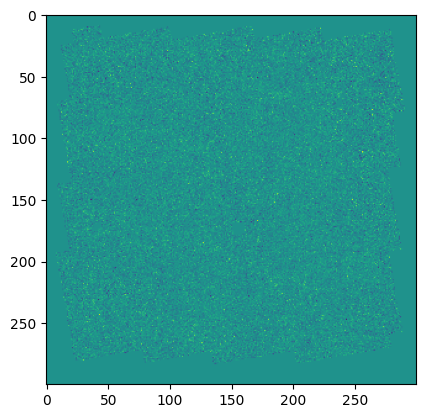

In [17]:
plt.imshow(normalized_gamma[:,:,0])